<img src="https://shwetkm.github.io/upxlogo.png"></img>


# Case study 3: Logistic regression model to predict credit card default

## Business Objective 


The dataset consists of 10000 individuals and whether their credit card has defaulted or not. 

**Objective :**  

Predict whether the individual will default in their credit card payment.

Below are the column description:
- **default** : Whether the individual has defaulted
- **student** : Whether the individual is student
- **balance** : The average balance that the customer has remaining on their credit card after making their monthly payment
- **income** : Income of individual



## Load Dataset

In [0]:
#Download dataset
#!wget -q https://www.dropbox.com/s/2ru004fjr6q13zm/default.csv

In [2]:
!ls

default.csv  sample_data


In [3]:
#Install Packages

#!pip -q install plotly-express
#!pip -q install shap
#!pip -q install eli5
#!pip -q install lime

     |████████████████████████████████| 81kB 3.1MB/s 
     |████████████████████████████████| 41.5MB 39.2MB/s 
     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 276kB 2.9MB/s 


## Import Packages

In [0]:
#Import basic packages

import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd               
import numpy as np
import pickle

from sklearn.model_selection import train_test_split   #splitting data
from pylab import rcParams
from sklearn.linear_model import LinearRegression         #linear regression
from sklearn.metrics.regression import mean_squared_error #error metrics
from sklearn.metrics import mean_absolute_error

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

%matplotlib inline     
sns.set(color_codes=True)




In [0]:
# Code for displaying plotly express plots inline in colab
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  
import plotly_express as px

## Read Data



### 1. Through Pandas

In [6]:
# Read data through Pandas and compute time taken to read

t_start = time.time()
df_credit = pd.read_csv('default.csv')
t_end = time.time()
print('pd.read_csv(): {} s'.format(t_end-t_start)) # time [s]
df_credit.head()

pd.read_csv(): 0.02562546730041504 s


default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879

### 2. Through Dask

In [7]:
# Read data through Dask and compute time taken to read

import dask.dataframe as dd

t_start = time.time()
df_dask = dd.read_csv('default.csv')
t_end = time.time()
print('dd.read_csv(): {} s'.format(t_end-t_start)) # time [s]
df_dask.tail()

dd.read_csv(): 0.01957416534423828 s


default student      balance        income
9995      No      No   711.555020  52992.378914
9996      No      No   757.962918  19660.721768
9997      No      No   845.411989  58636.156984
9998      No      No  1569.009053  36669.112365
9999      No     Yes   200.922183  16862.952321

**Observation**: Dask is almost 10 times faster than Pandas when reading files.

### 3. Subsample into n rows

In [0]:
# Sample n rows
n = df_credit.shape[0]
df_credit = df_credit.sample(n)

## Exploratory Data Analysis

### Let's look into summary statistics

In [9]:
#Let's look into the total number of columns and observations in the dataset
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 6251 to 1300
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [10]:
#Let's look into summary statistics of data
df_credit.describe()

balance        income
count  10000.000000  10000.000000
mean     835.374886  33516.981876
std      483.714985  13336.639563
min        0.000000    771.967729
25%      481.731105  21340.462903
50%      823.636973  34552.644802
75%     1166.308386  43807.729272
max     2654.322576  73554.233495

### Data Cleaning

#### Pandas profiling

In [0]:
#Perform Pandas profiling to understand quick overview of columns

import pandas_profiling
report = pandas_profiling.ProfileReport(df_credit)
#covert profile report as html file
report.to_file("credit_data.html")

In [13]:
from IPython.display import display,HTML,IFrame

display(HTML(open('credit_data.html').read()))

**Observation:**
- From Pandas profiling we understand there are no null values in any of the columns.

In [14]:
# count the number of NaN values in each column
print(df_credit.isnull().sum())

default    0
student    0
balance    0
income     0
dtype: int64


In [15]:
#The datatypes have now been changed
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 6251 to 1300
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


### Data Visualization

#### Let's analyze the distribution of balance when a customer defaults or does not default

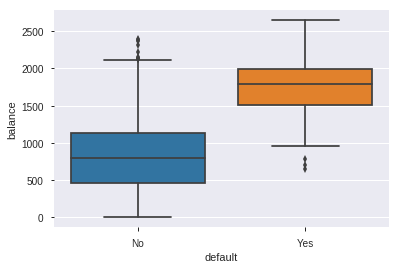

In [16]:
# Relation between balance and default
%matplotlib inline
sns.boxplot(x='default', y='balance', data=df_credit)
plt.show()

**Observation:** People who have more balance have defaulted more in their credit card payments.

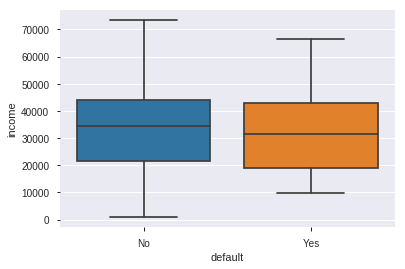

In [17]:
# Relation between income and default

sns.boxplot(x='default', y='income', data=df_credit)
plt.show()

**Observation:** There is not much relation between income and whether they have defaulted in their credit card payments.

#### Relation between balance and income and whether they have defaulted or not 

In [18]:
configure_plotly_browser_state()
px.scatter(df_credit, x="income", y="balance" ,color="default",
           hover_data=["student"], log_x=True, size_max=60)

**Observation**:People who have more balance have more defaults.

In [30]:
# Relation between Student and default

pd.crosstab(df_credit['default'], df_credit['student'], rownames=['Default'], colnames=['Student'])

Student    No   Yes
Default            
No       6850  2817
Yes       206   127

#### Correlation between selected variables

The heat map produces a correlation plot between variables of the dataframe.

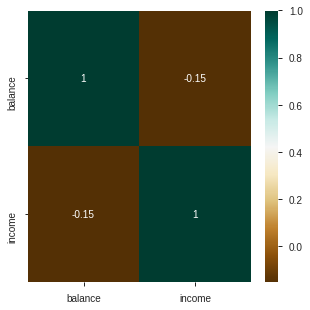

In [35]:
plt.figure(figsize=(5,5))
c = df_credit.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

**Observation**: The heat map illustrates that income and balance are negatively correlated.

#### Explore how often a student defaults

In [39]:
configure_plotly_browser_state()
px.box(df_credit, x="default", y="income", color="student",hover_data=['balance'],notched=True)

**Observation:** 

- Student defaulters are lesser as compared to others

## Model Building

###  Prepare the Data for model building

#### Perform one-hot encoding for categorical variables

In [66]:
#Select the variables to be one-hot encoded
one_hot_features = ['student', 'default']
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(df_credit[one_hot_features],drop_first=True)
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

# Convert Categorical to Numerical for default column


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 6251 to 1300
Data columns (total 2 columns):
student_Yes    10000 non-null uint8
default_Yes    10000 non-null uint8
dtypes: uint8(2)
memory usage: 417.7 KB


In [67]:
# Replacing categorical columns with dummies
fdf = df_credit.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)
fdf.head()

balance        income  student_Yes  default_Yes
6251   687.069131  34434.218234            0            0
5290    48.528096  16647.306161            1            0
9349   939.698674  52383.275216            0            0
7387  1357.693251  25389.830711            0            0
8137   925.706240  62764.884287            0            0

In [68]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 6251 to 1300
Data columns (total 4 columns):
balance        10000 non-null float64
income         10000 non-null float64
student_Yes    10000 non-null uint8
default_Yes    10000 non-null uint8
dtypes: float64(2), uint8(2)
memory usage: 573.9 KB


#### Standardization

In [0]:
#Standardize rows into uniform scale

X = fdf.drop(['default_Yes'],axis=1)
y = fdf['default_Yes']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# Scale and center the data
fdf_normalized = scaler.transform(X)

# Create a pandas DataFrame
fdf_normalized = pd.DataFrame(data=X, index=X.index, columns=X.columns)





#### Split the data into train and test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(fdf_normalized,y,random_state=1234,test_size=0.3)

### Train the model

In [96]:
# Building the Logistic Regression Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1)                            # Set Large C value for low regularization to prevent overfitting
logreg.fit(X_train, y_train)

print(logreg.coef_)                                            # Coefficients for Logistic Regression
print(logreg.intercept_)

[[ 3.85185551e-04 -1.24726400e-04 -2.56279498e-06]]
[-2.00956408e-06]


### Test the model

In [0]:
# now applying our learnt model on test and also on train data

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

### Metrics of the model

#### Accuracy of the model

In [98]:
from sklearn import metrics
# comparing the metrics of predicted lebel and real label of test data
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_pred_test))

Test Accuracy:  0.9666666666666667


In [99]:
# comparing the metrics of predicted lebel and real label of test data
print("Train Accuracy: ", metrics.accuracy_score(y_train, y_pred_train))

Train Accuracy:  0.9662857142857143


#### Null Accuracy

In [100]:
# Actual Values of y_test
y_test.value_counts()
y_test.value_counts().head(1) / len(y_test)

0    0.966667
Name: default_Yes, dtype: float64

**The null accuracy is 96.67%. There is only a slight improvement in accuracy for our model from the baseline model.**

Accuracy is not an appropriate metric in this scenario. We employ confusion matrix and ROC curve to further understand performance of our model on test data.

#### Confusion Matrix

In [0]:
conf=metrics.confusion_matrix(y_test, y_pred_test)

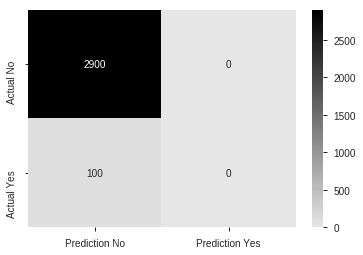

In [102]:
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['Prediction No','Prediction Yes'],yticklabels=['Actual No','Actual Yes'], annot=True,
            fmt='d')

**Observation**: Unfortunately, the model has not predicted any of the defaulters correctly.  

In [103]:
# Creating Classification Report

cr = metrics.classification_report(y_test, y_pred_test)
print(cr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2900
           1       0.00      0.00      0.00       100

    accuracy                           0.97      3000
   macro avg       0.48      0.50      0.49      3000
weighted avg       0.93      0.97      0.95      3000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



#### Imbalanced Data

The above metrics illustrate there is a clear imbalance in data.

Let us retrain our data using logistic regression this time using a parameter called 'balanced' which would handle imbalance in the data by changing the threshold set by logistic regression model:

In [104]:
# Building the Logistic Regression Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e42,class_weight='balanced')                            # Set Large C value for low regularization to prevent overfitting
logreg.fit(X_train, y_train)

print(logreg.coef_)                                            # Coefficients for Logistic Regression
print(logreg.intercept_)

[[ 5.69131491e-03  9.85896984e-06 -6.73269732e-01]]
[-7.62344407]


In [0]:
# now applying our learnt model on test and also on train data

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

In [106]:
from sklearn import metrics
# comparing the metrics of predicted lebel and real label of test data
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_pred_test))

Test Accuracy:  0.86


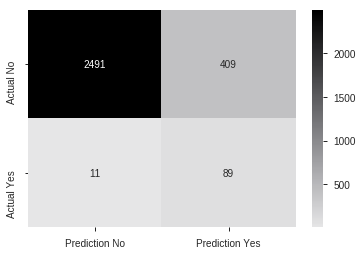

In [107]:
# creating a confusion matrix to understand the classification
conf = metrics.confusion_matrix(y_test, y_pred_test)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['Prediction No','Prediction Yes'],yticklabels=['Actual No','Actual Yes'], annot=True,
            fmt='d')

In [108]:
# Creating Classification Report

cr = metrics.classification_report(y_test, y_pred_test)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      2900
           1       0.18      0.89      0.30       100

    accuracy                           0.86      3000
   macro avg       0.59      0.87      0.61      3000
weighted avg       0.97      0.86      0.90      3000



#### ROC Curve

In [0]:
predict_probabilities = logreg.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_probabilities[:,1])

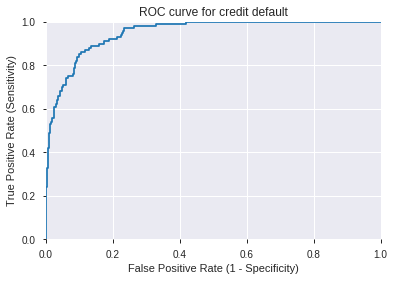

In [110]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for credit default')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Model Explainability

### LIME

In [112]:
# Import lime package
import lime
import lime.lime_tabular

#Find caegorical features
categorical_features = np.argwhere(np.array([len(set(X_test.values[:,x])) for x in range(X_test.values.shape[1])]) <= 10).flatten()
#Lime explainer for regression
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values,
feature_names=X_test.columns.values.tolist(),
class_names=['default'],
categorical_features=categorical_features,
verbose=True, mode='regression')
ind = 4
#Fit on test data
exp = explainer.explain_instance(X_test.values[ind], logreg.predict, num_features=3)
#Show in notebook features influencing predictions
exp.show_in_notebook(show_table=True)

Intercept -0.03642937606999436
Prediction_local [0.75835866]
Right: 1


### ELI5

In [115]:
# Import Eli5 package
import eli5
from eli5.sklearn import PermutationImportance

# Find the importance of columns for prediction
perm = PermutationImportance(logreg, random_state=1).fit(X_test,y_pred_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [104]:
#Understanding how each feature influences the prediction
eli5.show_prediction(model_fit, doc=X_test.iloc[[ind]], feature_names=list(X_test.columns))

### SHAP

In [116]:
#Import SHAP package
import shap

#Create explainer for linear model
explainer = shap.LinearExplainer(logreg,data=X_test.values)
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.6/dist-packages/shap/explainers/linear.py:47: UserWarning:

The default value for feature_dependence has been changed to "independent"!



In [120]:
#Understanding how each feature influences the prediction

shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns.tolist()
)

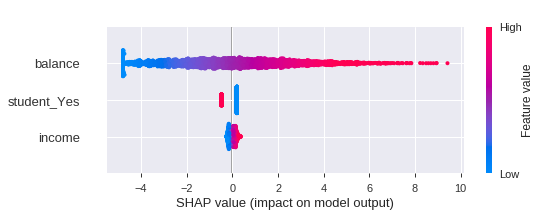

In [121]:

shap.summary_plot(shap_values,X_test)


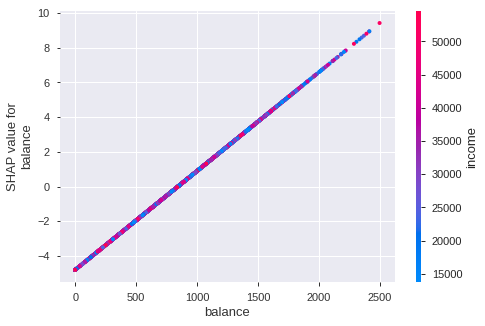

In [122]:
shap.dependence_plot("balance", shap_values, X_test)